In [3]:
pip install --user velocyto

     |████████████████████████████████| 204kB 3.9MB/s eta 0:00:01
     |████████████████████████████████| 51kB 11.7MB/s eta 0:00:01
     |████████████████████████████████| 51kB 17.0MB/s eta 0:00:01
  Stored in directory: /home/dan/.cache/pip/wheels/e0/10/47/5a2aa6a7179b17b50a19cdba1df71798ade77e7d9ce98c5300
  Stored in directory: /home/dan/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Stored in directory: /home/dan/.cache/pip/wheels/6c/fb/3d/5c43eb691bd92a3ddd0ebeb6e7e78ceaf3ae1cb8d54b89a7fb
Successfully built velocyto loompy numpy-groupies
Note: you may need to restart the kernel to use updated packages.


In [4]:
import velocyto
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import loompy
import pandas as pd
import scprep
import matplotlib
import os
import tarfile

In [5]:
home = os.path.expanduser('~')
download_path = os.path.join(home, 'scRNAseq', '2017_Krishnaswamy_EB_velocity.tar.gz')

# Download the data tarball
if not os.path.exists(download_path):
    scprep.io.download.download_google_drive('1FDDSWtSZcdQUVKpk-mPCZ8Ji1Fx8KSz9',download_path)

# Extract data directory
tf = tarfile.open(download_path)
tf.extractall(os.path.dirname(download_path))

# Format the data paths
data_dir = os.path.join(os.path.dirname(download_path), '2017_Krishnaswamy_EB_velocity')

#data_path = os.path.join(data_dir, 'Treutlein.expression.csv')
#metadata_path  = os.path.join(data_dir, 'Treutlein.groups.csv')

In [9]:
# Load the data
vlm = velocyto.VelocytoLoom(os.path.join(data_dir,'EBT_velocity.loom'))
keep_cells = set(np.load(os.path.join(data_dir,'EBT_filtered_cells.npy')))
phate_df = pd.read_pickle(os.path.join(data_dir,'EBT_phate_coordinates.pkl'))

In [10]:
# Get the list of kept barcodes from saved numpy, then filter vlm object by them
to_keep = np.array([1 if s in keep_cells else 0 for s in vlm.ca['CellID']]).astype(np.bool)
vlm.filter_cells(to_keep)

In [133]:
# Coerce the data into a nice format
phate_coords = np.array([phate_df[cid] for cid in vlm.ca['CellID']])
samples = ['EBT0_1A', 'EBT2_3B', 'EBT4_5C', 'EBT6_7D', 'EBT8_9E']
nice_samples = ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
vlm.ca['Sample'] = np.array([s[:7] for s in vlm.ca['CellID']])
sample_index_map = dict(zip(np.unique(vlm.ca['Sample']), range(5)))
sample_nice_map = dict(zip(samples, nice_samples))
vlm.ca['Sample_nice'] = np.array([sample_nice_map[s] for s in vlm.ca['Sample']])
vlm.ca['Sample_idx'] = np.array([sample_index_map[s] for s in vlm.ca['Sample']])
vlm.cluster_labels = vlm.ca['Sample_nice']

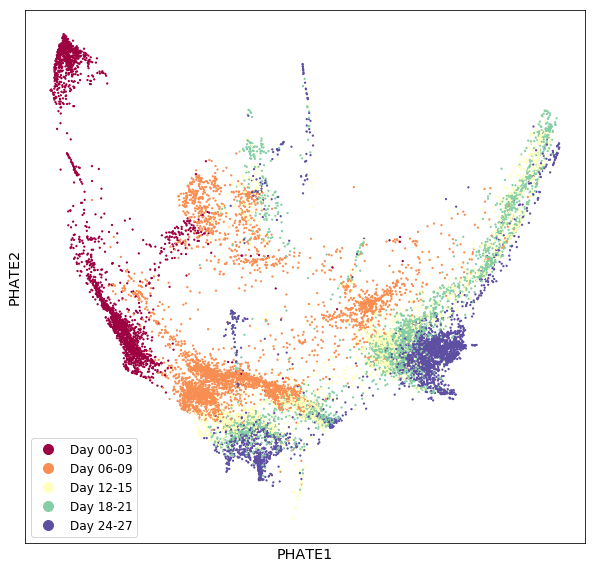

In [12]:
ax = scprep.plot.scatter2d(phate_coords, c=vlm.ca['Sample_nice'], figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")
ax.set_aspect('equal')

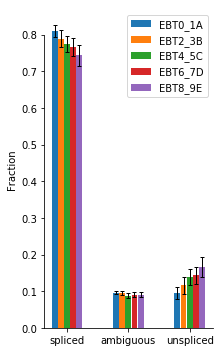

In [13]:
vlm.plot_fractions()

In [134]:
vlm.ts = phate_coords
cmap = matplotlib.cm.get_cmap('Spectral')
vlm.colorandum = np.array([dict(zip(samples, cmap(np.linspace(0,1,5))))[s] for s in vlm.ca['Sample']])

## Gene Filtering

### Score detection levels

Here we do a simple filtering based on the minimum number of cells in which a given gene is detected. We then throw away lowly expressed genes.

In [15]:
# Identify genes with adequate baseline expression
vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)

# Keep only genes passing detection threshold
vlm.filter_genes(by_detection_levels=True)

### Filter highly variable genes

Here, we only keep genes with a high coefficient of variation with respect to mean expression.

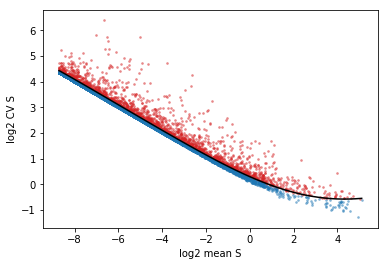

In [17]:
vlm.score_cv_vs_mean(3000, plot=True, max_expr_avg=35)
vlm.filter_genes(by_cv_vs_mean=True)

### Filter genes by cluster expression

Here, we keep genes that have adequate spliced and unspliced counts in clusters of the data. The following methods will do the clustering and ensure that we have sufficient spliced and unspliced counts throughout the full dataset.

In [30]:
# Consider number of spliced and unspliced counts globally
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0, 
                           min_expr_counts_U=25, min_cells_express_U=20)

# Consider number of spliced and unspliced counts in clusters
vlm.score_cluster_expression(min_avg_U=0.01, min_avg_S=0.08)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

### Normalize the spliced and unspliced counts by library size 

In [19]:
# Normalize Spliced and Unspliced gene expression matrices by library size.
vlm._normalize_S(relative_size=vlm.initial_cell_size,
                 target_size=np.mean(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size,
                 target_size=np.mean(vlm.initial_Ucell_size))

### Pick a number of principal components to use for kNN smoothing

Text(0, 0.5, 'Explained Variance')

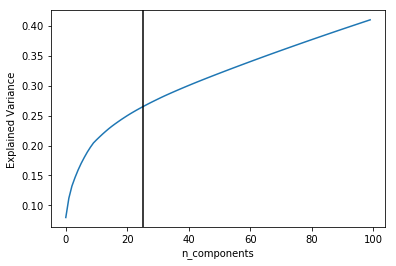

In [20]:
# Pick a number of PCA components
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
#n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = 25
plt.axvline(n_comps, c="k")
plt.xlabel('n_components')
plt.ylabel('Explained Variance')

### Gene smoothing

Because not all genes are detected in all cells, the ratio of spliced to unspliced is noisy (just like gene expression, but worse), we want to use local neighborhoods in the data to perform imputation and denoising. This is similar to the MAGIC algorithm discussed earlier, but it doesn't use diffusion. In the MAGIC paper, it was shown that MAGIC performs better than kNN for gene denoising, but this isn't our implementation, so we're not going to worry too much about that.

In [31]:
# Denoise the data using kNN

# Change k here to change how much denoising is performed
k = 5
vlm.knn_imputation(n_pca_dims=n_comps, k=k, 
                   # velocyto uses an algorithm called BalancedKNN
                   # for smoothing. These parameters are go directly
                   # to BalancedKNN
                   balanced=True, b_sight=k*8, b_maxl=k*4, 
                   n_jobs=-1)

### Estimate the rate of transcription

Here, we're going to estimate the rate of transcription for each gene. This involves estimating the steady-state expression for each gene and calculating the rate of transcription as a ratio of the spliced and unspliced molecules in each cell.

In [22]:
# Fit gamma (stable state unspliced to spliced ratio) 
# and calculate gene shift at all cells

# Learn steady-state U/S ratio
vlm.fit_gammas(limit_gamma=False, fit_offset=False)

# Estimate rate of transcription 
vlm.predict_U()

# Calculate individual cell "next state"
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_velocity")
vlm.extrapolate_cell_at_t(delta_t=1.)

## Gene Scatterplots

Now that we have estimated the rate of transcription and splicing for each cell, we can inspect how well these curves match the data we're observing. Remember that one assumption of RNA-velocity is that the rate of splicing is constant across all cells in a dataset.

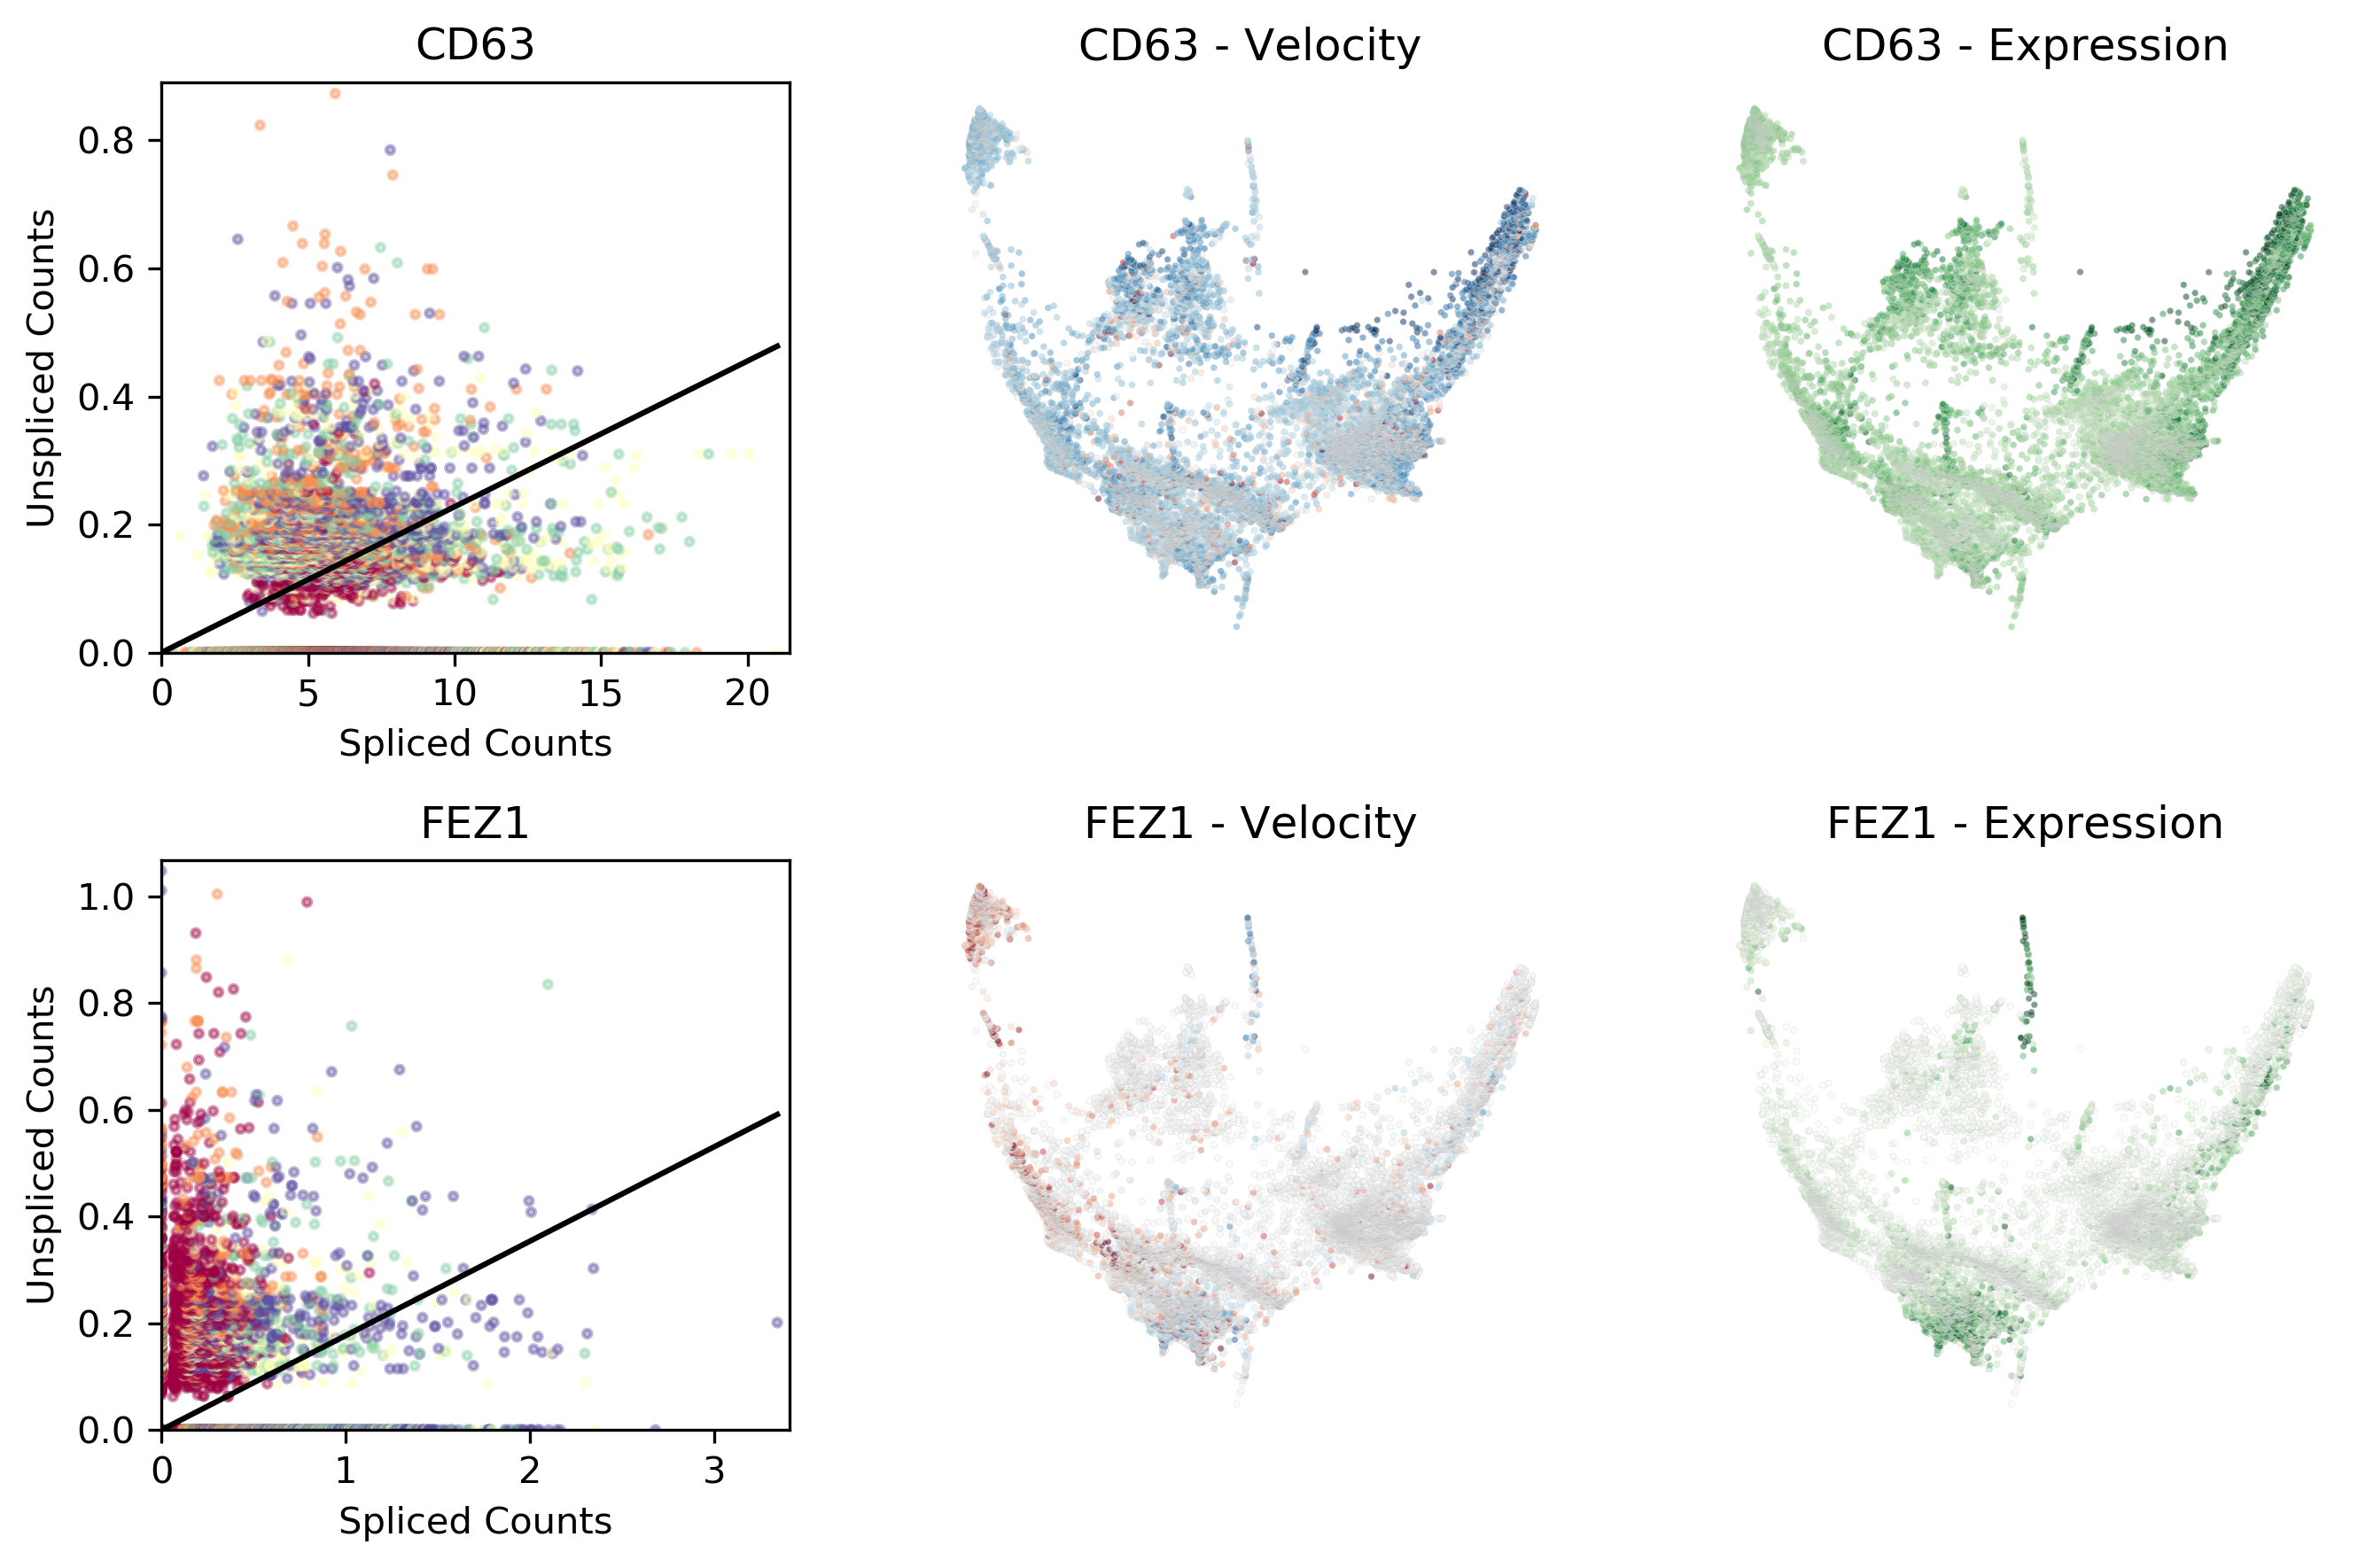

In [55]:
# Plot for a few genes the spliced and unspliced counts, as well as
# The calculated gene velocity, and expression at each cell.
fig = plt.figure(None, (9,6), dpi=300)
gs = plt.GridSpec(2,3)
for i, gn in enumerate(['CD63', 'FEZ1']):
#for i, gn in enumerate(["FOXD3", 'GATA6']):
    ax = plt.subplot(gs[i*3])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    velocyto.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], s=5, c=vlm.colorandum, alpha=0.4, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.02)
    plt.xlim(0, np.max(vlm.Sx_sz[ix,:])*1.02)
    plt.xlabel('Spliced Counts')
    plt.ylabel('Unspliced Counts')
    vlm.plot_velocity_as_color(gene_name=gn, gs=gs[i*3+1], s=3, rasterized=True)
    plt.title('{} - Velocity'.format(gn))
    vlm.plot_expression_as_color(gene_name=gn, gs=gs[i*3+2], s=3, rasterized=True)
    plt.title('{} - Expression'.format(gn))

plt.tight_layout()

In [49]:
for g in vlm.ra['Gene']:
    print(g)

MRPL20
ACOT7
ENO1
CTNNBIP1
SRM
RCC2
LUZP1
HNRNPR
ID3
SRSF10
UBXN11
IFI6
RPA2
SNRNP40
ZBTB8OS
YARS
CLSPN
MRPS15
COL9A2
P3H1
EBNA1BP2
PRDX1
RAB3B
TXNDC12
MAGOH
ITGB3BP
ARHGAP29
PSMA5
ALX3
SLC16A1
SYT6
TRIM33
ANP32E
S100A10
GPATCH4
TSTD1
DNM3OS
IVNS1ABP
ASPM
NUCKS1
EPRS
LBR
ENAH
PARP1
GNG4
PARK7
DRAXIN
PDPN
FBLIM1
ALPL
RPL11
CLIC4
LIN28A
HMGN2
SMPDL3B
ZCCHC17
CDCA8
AKIRIN1
NDUFS5
YBX1
PTPRF
KIF2C
NASP
UQCRH
HOOK1
NFIA
L1TD1
PGM1
ROR1
AK4
SRSF11
ST6GALNAC3
ST6GALNAC5
NEXN
IFI44L
CYR61
LMO4
CCDC18
SARS
PHGDH
MRPS21
FDPS
NUF2
ATP1B1
PRRX1
PRDX6
CACYBP
C1orf21
NAV1
SNRPE
LINC00467
ATF3
CENPF
CNIH4
SRP9
SDCCAG8
DESI2
COX20
IDI1
NUDT5
SEPHS1
HACD1
DNAJC1
SVIL
JMJD1C
PPA1
DNAJB12
P4HA1
ANXA11
ACTA2
PDLIM1
EXOSC1
MMS19
BLOC1S2
CUEDC2
ATP5MD
RAB11FIP2
EIF3A
CUZD1
OAT
NET1
GATA3
CELF2
CDC123
HSPA14
VIM
BAMBI
UBE2D1
CDK1
ARID5B
REEP3
DDX21
HK1
VCL
RPS24
PLAC9
KIF20B
HELLS
SCD
GSTO2
TCF7L2
BUB3
CARS
DKK3
RRAS2
RPS13
CCDC34
LINC00678
PAMR1
TIMM10
TRMT112
FAU
EFEMP2
AP002360.1
NDUFC2
PRCP
RAB38
CTSC
DC

#### Breakpoint - If you're done, help those around you!

### Estimate transition probabilities

Here we take the set of all predicted "next states" for each cell and estimate a future cell profile. Because each gene estimate is noisy, we take averages of neighbors.

This is the most computationally intensive step of RNA-velocity analysis, so it may take 1-3 minutes to finish.

Also, heads up, you may see several red warnings come up. You can ignore these. They are due to the velocyto implementation and not anything we've done here.

In [56]:
# Estimate the transition direction of each cell in gene space
# This is the most compuationally intensive step.
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=2000, knn_random=True, sampled_fraction=0.5, calculate_randomized=True,
                             n_jobs=-1)

/home/dan/.local/lib/python3.7/site-packages/velocyto/analysis.py:1569: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  p=p) for i in range(neigh_ixs.shape[0])), 0)


#### Calculate the next cell profile in the embedding space

Once we know the expected gene expression profile of each cell, we need to calculate where that cell would appear in the PHATE space to create the velocity plots.

In [57]:
# Calculate from the gene velocity vectors in the embedding space
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

# Calculate a 50x50 grid of velocities over the embedding space
vlm.calculate_grid_arrows(smooth=0.5, steps=(50, 50), n_neighbors=100)

## Plotting Velocity Vectors

These are the fancy plots highlighted in the RNA velocity paper. Each cell gets an arrow pointing to it's future cell state. You can see the flow of cell states throughout development!

(-116.9431496615558, 119.90876259493223, -94.98529068291008, 130.5978858969067)

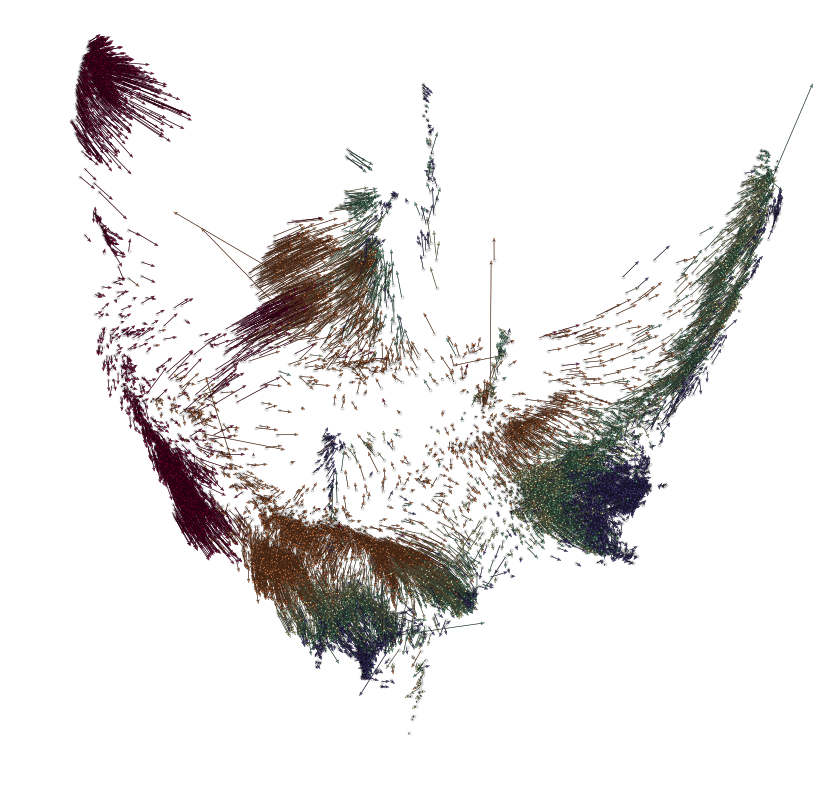

In [59]:
# Plot per cell velocity directions
plt.figure(None,(14,14))
quiver_scale = 10
q_scale=1
ix_choice = np.random.choice(vlm.embedding.shape[0], size=int(vlm.embedding.shape[0]/1.), replace=False)
plt.scatter(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1],
            c="0.8", alpha=0.4, s=10, edgecolor=(0,0,0,1), lw=0.3, rasterized=True)
quiver_kwargs=dict(headaxislength=7, headlength=11, headwidth=8,linewidths=0.25, width=0.00045,edgecolors="k", color=vlm.colorandum[ix_choice], alpha=1)
plt.quiver(vlm.embedding[ix_choice, 0], vlm.embedding[ix_choice, 1], 
           q_scale*vlm.delta_embedding[ix_choice, 0], q_scale*vlm.delta_embedding[ix_choice, 1],#units='xy',
           scale=quiver_scale, **quiver_kwargs)

plt.axis("off")

In [27]:
# How to get just the arrows
# np.concatenate([vlm.embedding, vlm.delta_embedding], axis=1)
# vlm.velocity is a per cell gene velocity vector

#### Plot arrows on a grid

Here we're plotting the average arrow for each section of the grid. This is a much "prettier" plot.

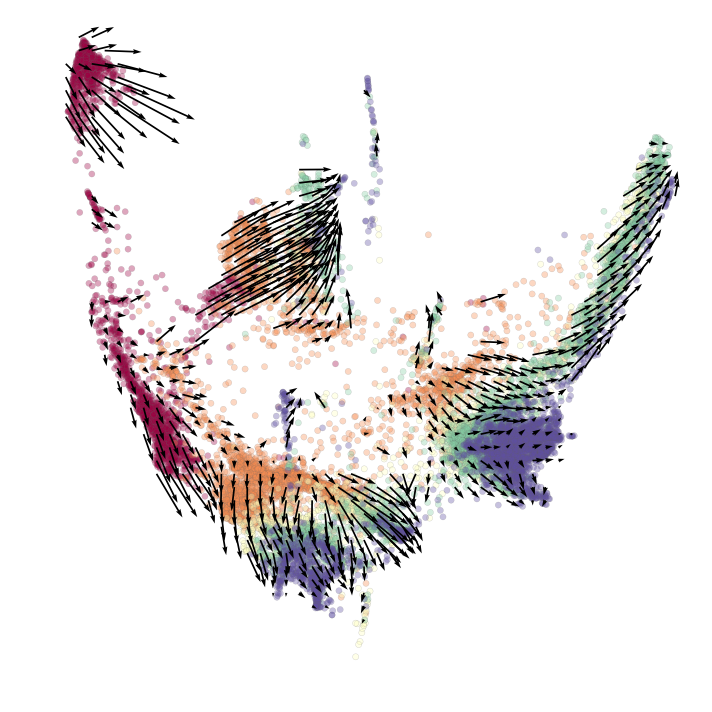

In [136]:
# Plot velocity on grid points smoothing cell velocities.
plt.figure(1,(10,10))

# Plot the arrows
vlm.plot_grid_arrows(quiver_scale=0.5,
     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
     "edgecolor":"0.4", "s":38, "rasterized":True},
     plot_random=False)

plt.tight_layout()
plt.savefig('/home/dan/burkhardt/SingleCellWorkshop/lectures/Trajectory_Inference/img/RNAvelocity.PHATE_grid.png', dpi=300)

### Identify genes with largest changing velocity

In [101]:
EBT_counts = pd.DataFrame(vlm.U + vlm.S, index=vlm.ra['Gene'], columns=vlm.ca['CellID']).T

In [115]:
EBT_counts = scprep.normalize.library_size_normalize(EBT_counts)
EBT_counts = scprep.transform.sqrt(EBT_counts)

In [131]:
phate_op = phate.PHATE(verbose=False).fit(EBT_counts)

phate_clusters = phate.cluster.kmeans(phate_op)

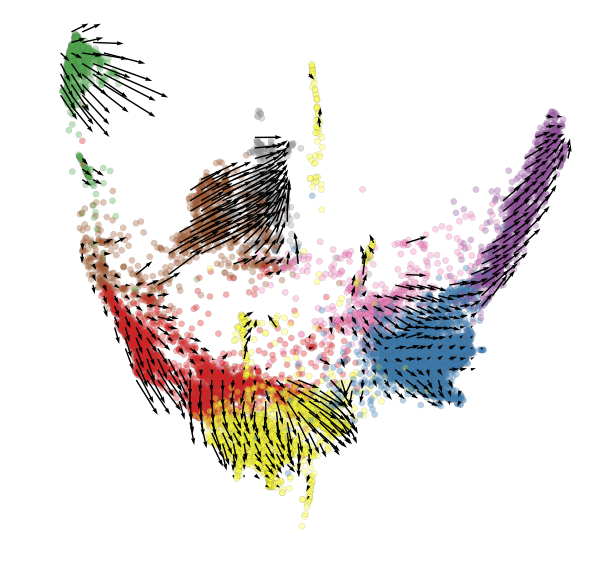

In [132]:
# Plot velocity on grid points smoothing cell velocities.
plt.figure(1,(10,10))

cmap = matplotlib.cm.get_cmap('Set1')
vlm.colorandum = np.array([dict(zip(np.unique(phate_clusters), 
                cmap(np.linspace(0,1,8))))[s] for s in phate_clusters])

# Plot the arrows
vlm.plot_grid_arrows(quiver_scale=0.5,
     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, 
     "edgecolor":"0.4", "s":38, "rasterized":True},
     plot_random=False)



In [121]:
velocity = pd.DataFrame(vlm.velocity, index=vlm.ra['Gene'], columns=vlm.ca['CellID']).T

In [130]:
mean_absolute_velocity_per_cluster = velocity.groupby(phate_clusters).mean().abs()

mean_absolute_velocity_per_cluster.loc[1].sort_values(ascending=False)

MALAT1     1.288223e+01
RPS3       1.029509e+01
RPS20      1.195368e+00
RPL34      9.355730e-01
RPLP2      9.009022e-01
               ...     
EDN3       2.292116e-05
DHFR       8.529276e-07
COL15A1    0.000000e+00
DNM3OS     0.000000e+00
IFI44L     0.000000e+00
Name: 1, Length: 1084, dtype: float64